In [5]:
kaggle_creds_path = "/content/kaggle.json"

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
!pip install kaggle --quiet

In [2]:
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
# Download the data from Kaggle: kaggle competitions download -c plant-seedlings-classification
!kaggle competitions download -c plant-seedlings-classification

 99% 1.67G/1.69G [00:22<00:00, 133MB/s]
100% 1.69G/1.69G [00:22<00:00, 79.4MB/s]


In [3]:
! mkdir kaggle_data
! unzip {'plant-seedlings-classification' + ".zip"} -d kaggle_data

Streaming output truncated to the last 5000 lines.
  inflating: kaggle_data/test/ad12382d4.png  
  inflating: kaggle_data/test/adb7a032c.png  
  inflating: kaggle_data/test/ae90f2827.png  
  inflating: kaggle_data/test/aecfaed64.png  
  inflating: kaggle_data/test/aee6fa3df.png  
  inflating: kaggle_data/test/af45e222a.png  
  inflating: kaggle_data/test/afa446484.png  
  inflating: kaggle_data/test/afcf6abd5.png  
  inflating: kaggle_data/test/b026bf8ca.png  
  inflating: kaggle_data/test/b03397525.png  
  inflating: kaggle_data/test/b0acaff4a.png  
  inflating: kaggle_data/test/b130a0632.png  
  inflating: kaggle_data/test/b145ba9d4.png  
  inflating: kaggle_data/test/b1cd2a91e.png  
  inflating: kaggle_data/test/b215531dd.png  
  inflating: kaggle_data/test/b2706e2b3.png  
  inflating: kaggle_data/test/b29339405.png  
  inflating: kaggle_data/test/b30ab4659.png  
  inflating: kaggle_data/test/b31292706.png  
  inflating: kaggle_data/test/b341d0aab.png  
  inflating: kaggle_data/test

In [4]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Activation,GlobalMaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [5]:
!ls

drive	     kaggle.json			 sample_data
kaggle_data  plant-seedlings-classification.zip


In [6]:
# Path to all images in training set. (* means include all folders and files.)
path = "/content/kaggle_data/train/**/*.png"
files = glob(path)

# Empty list to store the image data as numbers.
trainImg = [] 
# Empty list to store the labels of images
trainLabel = [] 
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print(str(j) + "/" + str(num), end="\r")
    # Get image (with resizing to 128x128)
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1
    
# Train images set
trainImg = np.asarray(trainImg)
# Train labels set
trainLabel = pd.DataFrame(trainLabel)  

In [7]:
print(trainImg.shape)
print(trainLabel.shape)

(4750, 128, 128, 3)
(4750, 1)


In [8]:
trainLabel[0].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: 0, dtype: int64

In [9]:
print(type(trainImg))
print(type(trainLabel))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


Text(0.5, 1.0, 'Maize')

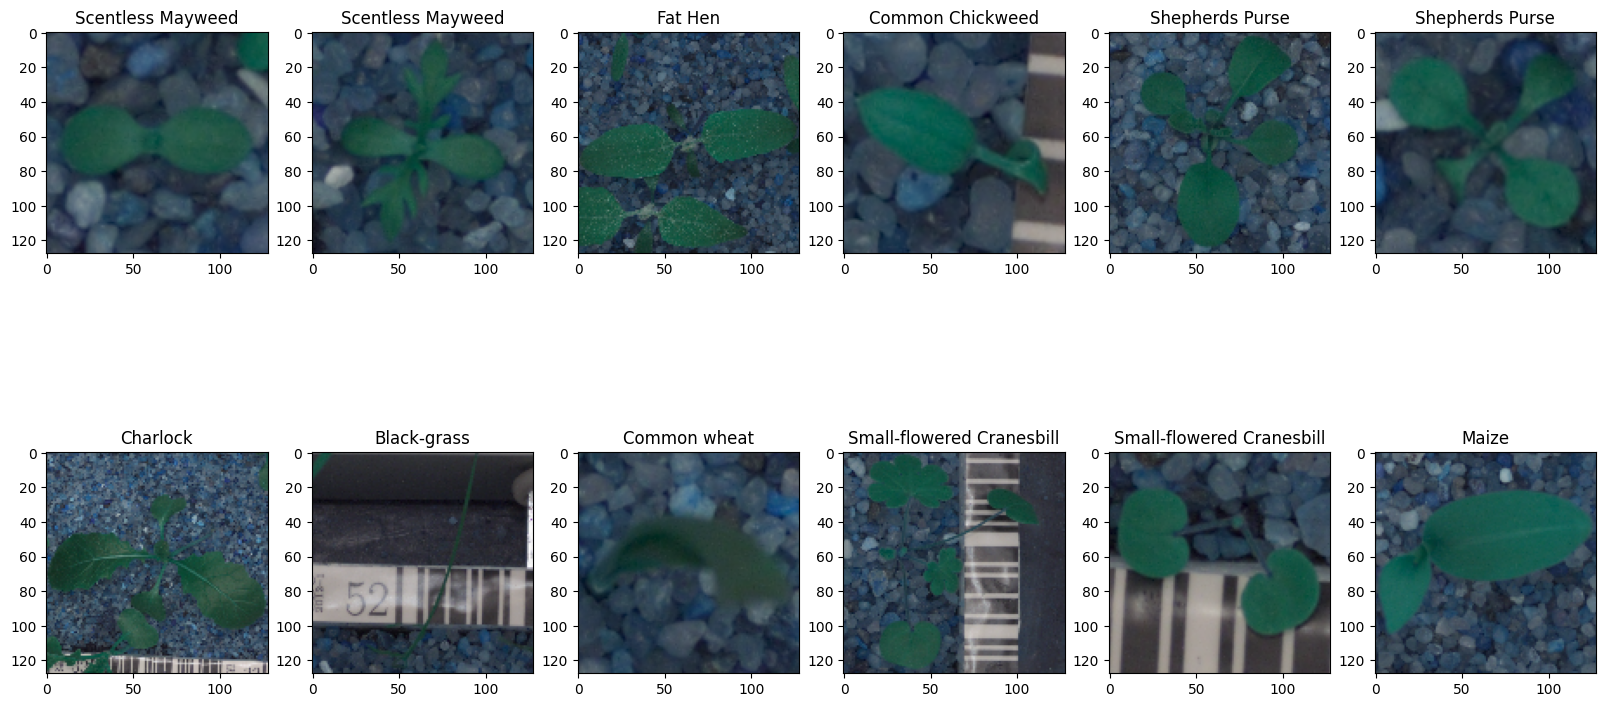

In [10]:
f = plt.figure(figsize=(20, 20))

f.add_subplot(2, 6, 1)
plt.imshow(trainImg[0])
plt.title(trainLabel[0][0])

f.add_subplot(2, 6, 2)
plt.imshow(trainImg[496])
plt.title(trainLabel[0][496])

f.add_subplot(2, 6, 3)
plt.imshow(trainImg[759])
plt.title(trainLabel[0][759])

f.add_subplot(2, 6, 4)
plt.imshow(trainImg[1370])
plt.title(trainLabel[0][1370])

f.add_subplot(2, 6, 5)
plt.imshow(trainImg[1755])
plt.title(trainLabel[0][1755])

f.add_subplot(2, 6, 6)
plt.imshow(trainImg[1685])
plt.title(trainLabel[0][1685])

f.add_subplot(1, 6, 1)
plt.imshow(trainImg[2409])
plt.title(trainLabel[0][2409])

f.add_subplot(1, 6, 2)
plt.imshow(trainImg[2630])
plt.title(trainLabel[0][2630])

f.add_subplot(1, 6, 3)
plt.imshow(trainImg[3020])
plt.title(trainLabel[0][3020])

f.add_subplot(1, 6, 4)
plt.imshow(trainImg[3251])
plt.title(trainLabel[0][3251])

f.add_subplot(1, 6, 5)
plt.imshow(trainImg[3538])
plt.title(trainLabel[0][3538])

f.add_subplot(1, 6, 6)
plt.imshow(trainImg[4749])
plt.title(trainLabel[0][4749])

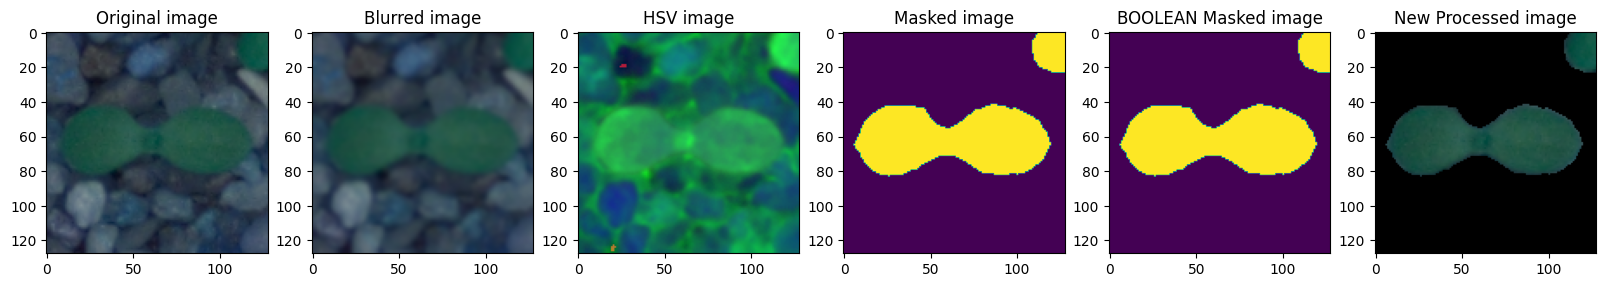

In [11]:
trainImg_new = []
sets = []; getEx = True

for i in trainImg:
    # Blurred image
    blurr = cv2.GaussianBlur(i,(5,5),0)
    # HSV image
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)

    #Green Parameters
    sensitivity = 35
    lower  = np.array([60 - sensitivity, 100, 50])
    upper = np.array([60 + sensitivity, 255, 255])

    #Masked image
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)

    #Boolean image
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    trainImg_new.append(new)

    if getEx:
        f = plt.figure(figsize=(20, 20))
        f.add_subplot(1,6,1);plt.imshow(i);plt.title('Original image') # Original image
        f.add_subplot(1,6,2);plt.imshow(blurr);plt.title('Blurred image') # Blurred image
        f.add_subplot(1,6,3);plt.imshow(hsv);plt.title('HSV image') # HSV image
        f.add_subplot(1,6,4);plt.imshow(mask);plt.title('Masked image') # Masked image
        f.add_subplot(1,6,5);plt.imshow(boolean);plt.title('BOOLEAN Masked image') # BOOLEAN Masked image
        f.add_subplot(1,6,6);plt.imshow(new);plt.title('New Processed image') # New Processed image
        getEx = False

trainImg_new = np.asarray(trainImg_new)

In [12]:
trainImg_new.shape

(4750, 128, 128, 3)

In [13]:
labels = preprocessing.LabelEncoder()
labels.fit(trainLabel[0])
print('Classes'+str(labels.classes_))


Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


In [14]:
encodedlabel = labels.transform(trainLabel[0])
convertedlabels = np_utils.to_categorical(encodedlabel)
classes = convertedlabels.shape[1]
print(str(classes))

12


In [15]:
# normalization of images
trainImg_new = trainImg_new.astype('float32') / 255.0

In [16]:
X_train,X_test,y_train,y_test = train_test_split(trainImg_new,convertedlabels,test_size=0.3,random_state=38,stratify=convertedlabels)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3325, 128, 128, 3)
(3325, 12)
(1425, 128, 128, 3)
(1425, 12)


In [18]:
X_val,X_test_new,y_val,y_test_new = train_test_split(X_test,y_test,test_size=0.5,random_state=38,stratify=y_test)

In [19]:
print(X_val.shape)
print(y_val.shape)
print(X_test_new.shape)
print(y_test_new.shape)

(712, 128, 128, 3)
(712, 12)
(713, 128, 128, 3)
(713, 12)


In [20]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [21]:
labels.classes_[10]

'Small-flowered Cranesbill'

CNN Model 5
4 convolution layers (filters=64/64/128/256, kernel_size=(3, 3) activation='relu')
MaxPool2D((2, 2)
Dropout(0.25)
GlobalMaxPool2D
Flatten
2 dense layers (256 / 256, activation='relu')
Dropout(0.25)
loss='categorical_crossentropy', optimizer='adam'
model compile with ImageDataGenerator to minimize overfitting.
shuffle = True

In [22]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(GlobalMaxPool2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                    

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

# Plot the model summary to a file
plot_model(model, to_file='model_summary.png', show_shapes=True)

In [23]:
generator = ImageDataGenerator(rotation_range = 180,
                               zoom_range = 0.2,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               horizontal_flip = True,
                               vertical_flip = True)
generator.fit(X_train)

In [24]:
history = model.fit(generator.flow(X_train,y_train,batch_size=64),epochs=200, verbose=2,shuffle=True,validation_data=(X_val,y_val))
pd.DataFrame(history.history)

Epoch 1/200
52/52 - 36s - loss: 2.3002 - accuracy: 0.1997 - val_loss: 2.0400 - val_accuracy: 0.2837 - 36s/epoch - 683ms/step
Epoch 2/200
52/52 - 19s - loss: 1.8884 - accuracy: 0.3026 - val_loss: 1.8954 - val_accuracy: 0.3399 - 19s/epoch - 361ms/step
Epoch 3/200
52/52 - 16s - loss: 1.8414 - accuracy: 0.3230 - val_loss: 1.8614 - val_accuracy: 0.2935 - 16s/epoch - 306ms/step
Epoch 4/200
52/52 - 16s - loss: 1.7911 - accuracy: 0.3380 - val_loss: 1.7409 - val_accuracy: 0.4073 - 16s/epoch - 315ms/step
Epoch 5/200
52/52 - 16s - loss: 1.6536 - accuracy: 0.3844 - val_loss: 1.6230 - val_accuracy: 0.4537 - 16s/epoch - 311ms/step
Epoch 6/200
52/52 - 17s - loss: 1.5293 - accuracy: 0.4559 - val_loss: 1.5370 - val_accuracy: 0.4649 - 17s/epoch - 323ms/step
Epoch 7/200
52/52 - 16s - loss: 1.3883 - accuracy: 0.5077 - val_loss: 1.3195 - val_accuracy: 0.5660 - 16s/epoch - 307ms/step
Epoch 8/200
52/52 - 16s - loss: 1.2920 - accuracy: 0.5338 - val_loss: 1.1506 - val_accuracy: 0.6166 - 16s/epoch - 311ms/step


,loss,accuracy,val_loss,val_accuracy
0,2.300212,0.199699,2.040022,0.283708
1,1.888362,0.302556,1.895391,0.339888
2,1.841432,0.323008,1.861405,0.293539
3,1.791105,0.338045,1.740936,0.407303
4,1.653578,0.384361,1.622977,0.453652
...,...,...,...,...
195,0.153810,0.941955,0.233289,0.910112
196,0.185329,0.929323,0.232772,0.918539
197,0.192233,0.930827,0.316166,0.876405
198,0.182735,0.931128,0.224872,0.912921


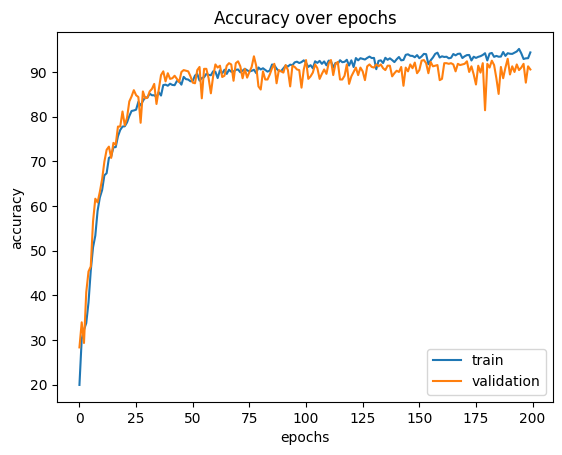

In [25]:

plt.plot(np.array(history.history['accuracy']) * 100)
plt.plot(np.array(history.history['val_accuracy']) * 100)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.title('Accuracy over epochs')
plt.show()

In [26]:

scores = model.evaluate(X_test_new, y_test_new)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 1s 32ms/step - loss: 0.2448 - accuracy: 0.8920
Test loss: 0.2448229044675827
Test accuracy: 0.8920056223869324


In [28]:
# confusion matrix function

def plot_confusion_matrix(cm, classes, normalize=False,title='Confusion matrix',cmap=plt.cm.Greens):

    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

23/23 [==============================] - 1s 21ms/step


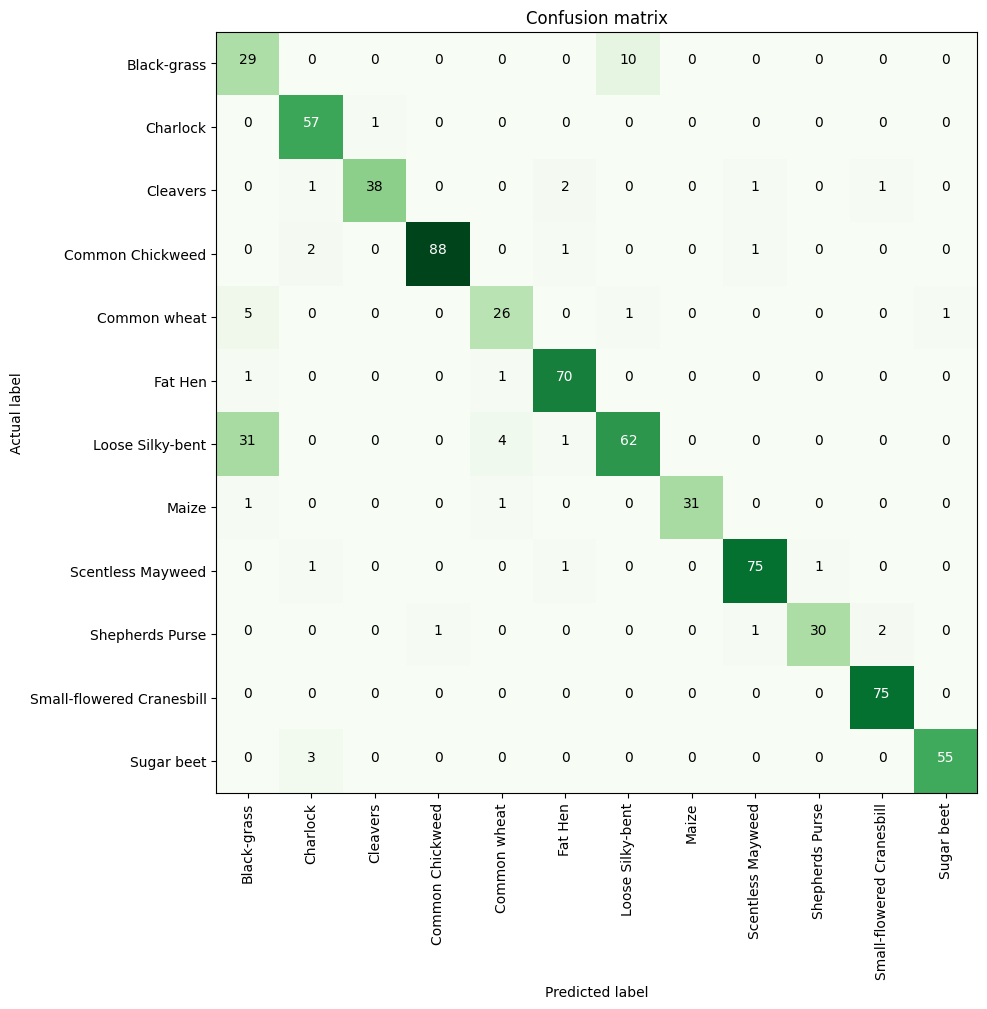

In [29]:

# Predict the values from the test data
y_pred = model.predict(X_test_new)
y_pred_Classes = np.argmax(y_pred, axis = 1)
trueY = np.argmax(y_test_new, axis = 1)

# confusion matrix
confusionMTX = confusion_matrix(trueY, y_pred_Classes)

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = labels.classes_)

In [ ]:

#Final score and accuracy of the model

score, acc = model.evaluate(X_test_new,y_test_new)
score1, acc1 = model.evaluate(X_train,y_train)
print('Test score:', score,'   Test accuracy:', acc)
print('Train score:', score1,'   Train accuracy:',acc1)


In [ ]:
test_images_path = "content/kaggle_data/test/*.png"

test_images = glob(test_images_path)
test_images_arr = []
test_files = []

for img in test_images:

    i = cv2.resize(cv2.imread(img), (128, 128))
    test_files.append(img.split('/')[-1])

    # Blurred image
    blurr = cv2.GaussianBlur(i,(5,5),0)

    # HSV image
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)

    #Green Parameters
    sensitivity = 35
    lower  = np.array([60 - sensitivity, 100, 50])
    upper = np.array([60 + sensitivity, 255, 255])

    #Masked image
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)

    #Boolean image
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    test_images_arr.append(new)

test_X = np.asarray(test_images_arr)

# Normalization of the Image Data
test_X = test_X.astype('float32') / 255

In [ ]:

predictions = model.predict(test_X)
preds = np.argmax(predictions, axis=1)
pred_str = labels.classes_[preds]


final_predictions = {'file':test_files, 'species':pred_str}
final_predictions = pd.DataFrame(final_predictions)
final_predictions.to_csv("./temp_train/submission.csv", index=False)

In [30]:
model.save('CNN.h5')

In [31]:
from tensorflow.keras.models import load_model

loaded_model = load_model('CNN.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                    

In [1]:
test_images_path = "/content/Wild/*.png"

test_images = glob(test_images_path)
test_images_arr = []
test_files = []

for img in test_images:

    i = cv2.resize(cv2.imread(img), (128, 128))
    test_files.append(img.split('/')[-1])

    # Blurred image
    blurr = cv2.GaussianBlur(i,(5,5),0)

    # HSV image
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)

    #Green Parameters
    sensitivity = 35
    lower  = np.array([60 - sensitivity, 100, 50])
    upper = np.array([60 + sensitivity, 255, 255])

    #Masked image
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)

    #Boolean image
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    test_images_arr.append(new)

test_X = np.asarray(test_images_arr)

# Normalization of the Image Data
test_X = test_X.astype('float32') / 255

NameError: ignored

In [46]:
predictions = loaded_model.predict(test_X)

1/1 [==============================] - 0s 43ms/step


In [49]:
max_idx = np.argmax(predictions)
print(max_idx)

9
